### Using a Logistic classifier for digit regonition.

In this example, images of handwritten numbers, are identified as to which digit each is.    

Logistic classification is based upon first optaining scores from a linear model.

The model will calculate a score for 

$$ y = WX + b $$

X is our input vector.  W is a matrix of weights and b is the bias.

Durning the learning phase y is the labels that have been provided with the training set.



In [94]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [95]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


the parameter `one_hot=True` gives labels that are "one hot" encoded.  The label for each image is a 10 element array (one element for each digit).  For each sample the correct array element has a value of 1 and all others are 0.

In [96]:
mnist.train.labels.shape

(55000, 10)

In [99]:
mnist.train.images.shape

(55000, 784)

In [100]:
tf.reshape(mnist.train.images, [-1])

<tf.Tensor 'Reshape_4:0' shape=(43120000,) dtype=float32>

In [101]:
mnist.train.images.shape

(55000, 784)

In [103]:
plt.hist(tf.reshape(mnist.train.images, [-1]).eval())

(array([ 35609257.,    524055.,    471209.,    401079.,    409263.,
           461877.,    430081.,    475686.,    560682.,   3776811.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

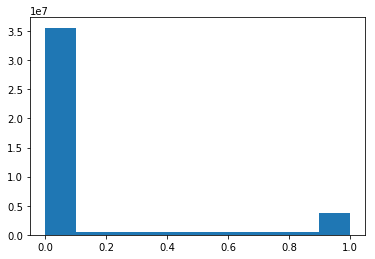

In [104]:
plt.show() 

One thing to note about the MNIST dataset is that it is not well distributed.  If there is a good way to recondition the data, it should be explored.

In [105]:
# Create a variable matrix for W and a variable vector for b.  
# These are what will be optimized by the learning phase.

# W = tf.Variable(tf.zeros([784, 10])) # Here we created variables initialized with all zero values
# b = tf.Variable(tf.zeros([10])) 

rand_init_W = tf.random_normal([784, 10], 0, 0.2) # Initialize with random values from a normal distribution.
rand_init_b = tf.random_normal([10], 0, 0.2)

W = tf.Variable(rand_init_W)
b = tf.Variable(rand_init_b)

# Create a placeholder variable for the image data

x = tf.placeholder(tf.float32, [None, 784])

The linear equation that is our model can be expressed as a matrix equation.  

The score for each image is a vector given by:

$$ evidence_i = \sum_j W_{ij}x_{j} + b_{ij} $$

Here i is the digit outcome (0-9).  x is a vector of the image data (the image data is flatten to a 1D array in this example).

To do the evidence sum for all digits at once, do a matrix multiply:

In [106]:
# We are building the model before initializing the data into it.

evidence = tf.matmul(x, W) + b

order of operations matters in matrix ops (but x is a vector, does this matter here (have students check)).  Wether the vector is row or column matters here.  (This will be covered eariler, so this question should be review).

In [107]:
# The softmax distribution converts the scores into a proability (where the sum of the probabilities is one)

y = tf.nn.softmax(evidence)

The scores are the y values in the first equation.

In [108]:
# This variable is for the correct values of the training set (the labels)

y_ = tf.placeholder(tf.float32, [None, 10])

Now, we need an error between predicted and actual values to minimize.  The cross entropy evaluates the distance between the predicted and correct vectors.

In [109]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), axis=1))

The reduce_sum term calculates the .  Using mean in the second term rather then sum, keeps the value of the cross entropy smaller which is better for numerial stability when optimizing.

An alturnative calculation of cross entropy is the softmax_cross_entropy_with_logits function.  This impliments the softmax and cross entropy calculations together in a more numerially stable way.

In [80]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=evidence))

In [110]:
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)

In [111]:
sess = tf.InteractiveSession()

In [112]:
tf.global_variables_initializer().run()

In [113]:
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

Here we are randomly selecting 100 images and their labels to train on and repeating 1000 times.  This is an example of stochastic gradient descent.  It would be very computational expensive (and less numerically stable) to do gradient desent on 55000 samples.

Exercise:  Test the effect of batch size on the on the training effectivness.  

The tf.argmax function gives the index of the highest value in a tensor.

In [114]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [115]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [116]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.8816


90% - 1000, 100 sample batches
no improvement for 200 sample batches
no significant loss for 50 sample batches

86% - 100 100 sample batches
57% - 10 100 sample batches

90% is not a very good predictor for clean data like MNIST

The number of training steps effects the training more than the batch size in stochastic gradient descent

### Improving results with a convolutional neural network (CNN)

In this network we will use a different activation function. 

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [ ]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')